# Librairies import


In [1]:
import warnings
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import dateutil
import seaborn as sns
import sys
from IPython.display import clear_output
from sklearn.preprocessing import OneHotEncoder
from itertools import islice
warnings.filterwarnings('ignore')

pd.set_option('display.max_row', 1000)
# allow to display 200 columns of the dataset:
pd.set_option('display.max_column', 200)
# useful to see all features


# Variables initialization


In [49]:
bigData = []  # created datasets list
bigOdds = []  # odds datasets list
df = pd.DataFrame({})  # dataframe
ranking = pd.DataFrame({})  # ranking dataframe
new_col_list = ['HWRate', 'HDRate', 'AWRate', 'ADRate', 'GSDiff', 'GADiff', 'SDiff', 'STDiff', 'FDiff',
                'CDiff', 'YCDiff', 'RCDiff']  # list of new columns
rk_col_list = ['Rank', 'Team', 'Games Played', 'Points', 'Goals Scored', 'Goals Against',
               'Goal Difference']  # list of columns for ranking dataframe
nb_teams = 0  # number of teams in the championship
game = 0  # match number in championship
directory = os.fsencode('database/')  # working directory


# Functions definition


In [50]:
def load_dataframe(file, directory=directory):
    # charge dataset
    return pd.read_csv(os.fsdecode(directory)+os.fsdecode(file))


In [51]:
def find_csv(directory=directory):
    return [os.fsdecode(file) for file in os.listdir(directory) if (file.endswith(os.fsencode('.csv')))]


In [52]:
def find_from_season(filelist, season=17):
    return [os.fsdecode(file) for file in filelist if int(os.fsdecode(file)[-8:-4]) > (season-1)*100]


In [53]:
def concatenate_df(filelist):
    df_list = []
    for file in filelist:
        df_list.append(pd.read_csv(os.fsdecode(directory)+file))
    return pd.concat(df_list, join='inner', ignore_index=True)


In [54]:
# Create dataset from fivethirtyeight spi rating file, for the top 5 leagues last 7 seasons
data_spi = load_dataframe('soccer-spi/spi_matches.csv')
data_spi = data_spi[(data_spi.league_id == 1843) | (data_spi.league_id == 2411) |
                    (data_spi.league_id == 1869) | (data_spi.league_id == 1854) | (data_spi.league_id == 1845)].reset_index()

# Create one dataset from multiple files, extracted from football-data.co.uk, in order to match dataset from
# fivethirtyeight

# List of all files names in the database, excluding non-csv files
allfilenames = find_csv()
# Selection of file names referring to seasons starting from 2016-2017
filenames = find_from_season(allfilenames)
# Create a list of every dataset necessary then concatenate them into a big dataset
data_fd = concatenate_df(filenames)


In [55]:
def ranges(nums):
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return list(zip(edges, edges))


In [56]:
def importance(team, season, data):
    importance_list = []
    na_index = []
    importance_df = data[(data['season'] == season) & (
        (data['team1'] == team) | (data['team2'] == team))]
    for index, game in importance_df.iterrows():
        if game.team1 == team:
            importance_list.append(game.importance1)
        elif game.team2 == team:
            importance_list.append(game.importance2)
    for item in importance_list:
        if math.isnan(item):
            na_index.append(importance_list.index(item))
    return importance_list, na_index


In [57]:
def nbt(df=df):
    try:
        nb_teams = df['HomeTeam'].nunique()  # count number of teams
        return nb_teams
    except TypeError:
        pass
    except KeyError:
        try:
            sys.exit(0)
        except SystemExit:
            print('Error: wrong columns in input files. Stopping...')
        except:
            print('Error unknown.')


In [58]:
def create_ranking_df(rk_col_list=rk_col_list, nb_teams=nb_teams, df=df):
    # Create an empty dataframe to store teams ranking during a championship
    ranking = pd.DataFrame({})
    for col in rk_col_list:
        if col == 'Team':
            teams = pd.concat([df['HomeTeam'], df['AwayTeam']]).drop_duplicates()
            ranking[col] = pd.Series(teams.unique())
        elif col == 'Rank':
            ranking[col] = np.array([i for i in range(1, nb_teams+1)])
        else:
            ranking[col] = np.zeros(nb_teams).astype('int64')
    return ranking


In [59]:
def update_ranking_generic(ranking=ranking, df=df, game=game):
    # teams name
    home_team, away_team = df['HomeTeam'][game], df['AwayTeam'][game]
    # update number of games played
    ranking['Games Played'][ranking['Team'] == home_team] += 1
    ranking['Games Played'][ranking['Team'] == away_team] += 1

    # update points
    if df['FTR'][game] == 'H':
        ranking['Points'][ranking['Team'] == home_team] += 3
    elif df['FTR'][game] == 'A':
        ranking['Points'][ranking['Team'] == away_team] += 3
    elif df['FTR'][game] == 'D':
        ranking['Points'][ranking['Team'] == home_team] += 1
        ranking['Points'][ranking['Team'] == away_team] += 1
    else:
        print('Error: wrong value for FTR column. Must be \'H\', \'D\' or \'A\'')

    # update goals scored and against
    ranking['Goals Scored'][ranking['Team'] == home_team] += df['FTHG'][game]
    ranking['Goals Against'][ranking['Team'] == home_team] += df['FTAG'][game]
    ranking['Goal Difference'][ranking['Team']
                               == home_team] += df['FTHG'][game]
    ranking['Goal Difference'][ranking['Team']
                               == home_team] -= df['FTAG'][game]
    ranking['Goals Scored'][ranking['Team'] == away_team] += df['FTAG'][game]
    ranking['Goals Against'][ranking['Team'] == away_team] += df['FTHG'][game]
    ranking['Goal Difference'][ranking['Team']
                               == away_team] += df['FTAG'][game]
    ranking['Goal Difference'][ranking['Team']
                               == away_team] -= df['FTHG'][game]

    # sort teams by points
    ranking = ranking.sort_values(
        by=['Points'], ascending=[False])
    ranking.index = pd.RangeIndex(0, len(ranking.index))

    # update ranks
    if ((game < len(df.index)-1) and (df['Date'][game+1] != df['Date'][game])) or (game == len(df.index)-1):
        for i in ranking.index:
            ranking.loc[i, 'Rank'] = i+1
        for i in ranking.index:
            if i < max(ranking.index):
                if (ranking['Points'].iloc[i] == ranking['Points'].iloc[i+1]):
                    mutual_rank = ranking.at[i, 'Rank']
                    ranking.at[i+1, 'Rank'] = mutual_rank
        
    return ranking


In [60]:
def tiebreaking_ligue_1(ranking=ranking, df=df, game=game):
    # LEVEL 1 - OVERALL GOAL DIFFERENCE
    # Group the dataframe by the 'Points' column
    grouped_l1 = ranking.groupby('Rank')

    # Sort each group by 'Goals Scored' in descending order
    def sort_group_l1(group):
        return group.sort_values(by='Goal Difference', ascending=False)

    ranking = grouped_l1.apply(sort_group_l1)

    # Reset the index to start from 0
    ranking.reset_index(drop=True, inplace=True)

    # update ranks
    if ((game < len(df.index)-1) and (df['Date'][game+1] != df['Date'][game])) or (game == len(df.index)-1):
        for i in ranking.index:
            ranking.loc[i, 'Rank'] = i+1
        for i in ranking.index:
            if i < max(ranking.index):
                tie_condition_l1 = (ranking['Points'].iloc[i] == ranking['Points'].iloc[i+1]) &\
                    (ranking['Goal Difference'].iloc[i] ==
                     ranking['Goal Difference'].iloc[i+1])
                if tie_condition_l1:
                    mutual_rank = ranking.at[i, 'Rank']
                    ranking.at[i+1, 'Rank'] = mutual_rank

    # LEVEL 2 & 3 - SPECIFIC POINT DIFFERENCE & GOAL DIFFERENCE
    # Create small dataframes with already played games between tied teams
    ranking = ranking.assign(Specific_points=0)
    ranking = ranking.assign(Specific_GD=0)
    grouped_l2_l3 = ranking.groupby('Rank')

    def fetch_tied_games(group, df, game):
        if len(group) == 1:
            return None
        else:
            return df[(df['HomeTeam'].isin(group['Team'])) & (df['AwayTeam'].isin(group['Team'])) &
                      (df.index <= game)]

    for name, group in grouped_l2_l3:
        if len(group) > 1:
            tied_games = fetch_tied_games(group, df, game)
            for index, row in tied_games.iterrows():
                goal_diff = row['FTHG'] - row['FTAG']
                ranking['Specific_GD'][ranking['Team']
                                       == row['HomeTeam']] += goal_diff
                ranking['Specific_GD'][ranking['Team']
                                       == row['AwayTeam']] -= goal_diff
                if row['FTR'] == 'H':
                    ranking['Specific_points'][ranking['Team']
                                               == row['HomeTeam']] += 3
                elif row['FTR'] == 'D':
                    ranking['Specific_points'][ranking['Team']
                                               == row['HomeTeam']] += 1
                    ranking['Specific_points'][ranking['Team']
                                               == row['AwayTeam']] += 1
                elif row['FTR'] == 'A':
                    ranking['Specific_points'][ranking['Team']
                                               == row['AwayTeam']] += 3

    # Sort each group by Specific Points then Specific Goal Difference in descending order
    def sort_group_l2_l3(group):
        return group.sort_values(by=['Specific_points', 'Specific_GD'], ascending=[False, False])

    ranking = grouped_l2_l3.apply(sort_group_l2_l3)

    # Reset the index to start from 0
    ranking.reset_index(drop=True, inplace=True)

    # update ranks
    if ((game < len(df.index)-1) and (df['Date'][game+1] != df['Date'][game])) or (game == len(df.index)-1):
        for i in ranking.index:
            ranking.loc[i, 'Rank'] = i+1
        for i in ranking.index:
            if i < max(ranking.index):
                tie_condition_l2 = (ranking['Specific_points'].iloc[i] == ranking['Specific_points'].iloc[i+1])\
                    & (ranking['Specific_GD'].iloc[i] == ranking['Specific_GD'].iloc[i+1])
                if tie_condition_l1 & tie_condition_l2:
                    mutual_rank = ranking.at[i, 'Rank']
                    ranking.at[i+1, 'Rank'] = mutual_rank

    return ranking


In [61]:
def update_ranking_premier_league(ranking=ranking, df=df, game=game):
    # teams name
    home_team, away_team = df['HomeTeam'][game], df['AwayTeam'][game]
    # update number of games played
    ranking['Games Played'][ranking['Team'] == home_team] += 1
    ranking['Games Played'][ranking['Team'] == away_team] += 1

    # update points
    if df['FTR'][game] == 'H':
        ranking['Points'][ranking['Team'] == home_team] += 3
    elif df['FTR'][game] == 'A':
        ranking['Points'][ranking['Team'] == away_team] += 3
    elif df['FTR'][game] == 'D':
        ranking['Points'][ranking['Team'] == home_team] += 1
        ranking['Points'][ranking['Team'] == away_team] += 1
    else:
        print(f'Error: wrong value for FTR column. Must be \'H\', \'D\' or \'A\'. Check index {game}.')

    # update goals scored and against
    ranking['Goals Scored'][ranking['Team'] == home_team] += df['FTHG'][game]
    ranking['Goals Against'][ranking['Team'] == home_team] += df['FTAG'][game]
    ranking['Goal Difference'][ranking['Team']
                               == home_team] += df['FTHG'][game]
    ranking['Goal Difference'][ranking['Team']
                               == home_team] -= df['FTAG'][game]
    ranking['Goals Scored'][ranking['Team'] == away_team] += df['FTAG'][game]
    ranking['Goals Against'][ranking['Team'] == away_team] += df['FTHG'][game]
    ranking['Goal Difference'][ranking['Team']
                               == away_team] += df['FTAG'][game]
    ranking['Goal Difference'][ranking['Team']
                               == away_team] -= df['FTHG'][game]

    # sort teams by points, then goal diff, the goals scored
    ranking = ranking.sort_values(
        by=['Points', 'Goal Difference', 'Goals Scored'], ascending=[False, False, False])
    ranking.index = pd.RangeIndex(0, len(ranking.index))

    # update ranks
    if (game < len(df.index)-1) and (df['Date'][game+1] != df['Date'][game]):
        index_iter = iter(ranking.index)
        skip = 0
        for i in index_iter:
            if skip > 0:
                skip -= 1
                continue

            ranking['Rank'][i] = i+1
            two_teams_tied = False
            three_teams_tied = False
            four_teams_tied = False

            if i < 4:
                two_teams_tied = (ranking['Points'][i] == ranking['Points'][i+1]) &\
                    (ranking['Goal Difference'][i] == ranking['Goal Difference'][i+1]) &\
                    (ranking['Goals Scored'][i] == ranking['Goals Scored'][i+1]) &\
                    (not ((ranking['Points'][i+1] == ranking['Points'][i+2]) &
                          (ranking['Goal Difference'][i+1] == ranking['Goal Difference'][i+2]) &
                          (ranking['Goals Scored'][i+1] == ranking['Goals Scored'][i+2])))

                three_teams_tied = (ranking['Points'][i] == ranking['Points'][i+1] == ranking['Points'][i+2]) &\
                    (ranking['Goal Difference'][i] == ranking['Goal Difference'][i+1] ==
                        ranking['Goal Difference'][i+2]) &\
                    (ranking['Goals Scored'][i] == ranking['Goals Scored'][i+1] ==
                        ranking['Goals Scored'][i+2]) &\
                    (not ((ranking['Points'][i] == ranking['Points'][i+3]) &
                          (ranking['Goal Difference'][i] == ranking['Goal Difference'][i+3]) &
                          (ranking['Goals Scored'][i] == ranking['Goals Scored'][i+3]))
                     )

                four_teams_tied = (ranking['Points'][i] == ranking['Points'][i+1] == ranking['Points'][i+2] ==
                                   ranking['Points'][i+3]) &\
                    (ranking['Goal Difference'][i] == ranking['Goal Difference'][i+1] ==
                        ranking['Goal Difference'][i+2] == ranking['Goal Difference'][i+3]) &\
                    (ranking['Goals Scored'][i] == ranking['Goals Scored'][i+1] ==
                        ranking['Goals Scored'][i+2] == ranking['Goals Scored'][i+3]) &\
                    (not ((ranking['Points'][i] == ranking['Points'][i+4]) &
                          (ranking['Goal Difference'][i] == ranking['Goal Difference'][i+4]) &
                          (ranking['Goals Scored'][i] == ranking['Goals Scored'][i+4]))
                     )

                teams = []
                if two_teams_tied:
                    skip = 1
                    teams = [ranking['Team'][i], ranking['Team'][i+1]]
                elif three_teams_tied:
                    skip = 2
                    teams = [ranking['Team'][i], ranking['Team']
                             [i+1], ranking['Team'][i+2]]
                elif four_teams_tied:
                    skip = 3
                    teams = [ranking['Team'][i], ranking['Team'][i+1], ranking['Team'][i+2],
                             ranking['Team'][i+3]]

                tied_games = df[(df['HomeTeam'].isin(
                    teams)) & (df['AwayTeam'].isin(teams)) & (df.index < game)]

                if ((two_teams_tied) or (three_teams_tied) or (four_teams_tied)):# & (len(tied_games) > 0):
                    print(game, teams)
                    mini_ranking = create_ranking_df(
                        rk_col_list=ranking.columns, nb_teams=len(teams), df=tied_games)

            elif (i < max(ranking.index) - 3):

                two_teams_tied = (ranking['Points'][i] == ranking['Points'][i-1]) &\
                    (ranking['Goal Difference'][i] == ranking['Goal Difference'][i-1]) &\
                    (ranking['Goals Scored'][i] == ranking['Goals Scored'][i-1]) &\
                    (not ((ranking['Points'][i] == ranking['Points'][i-2]) &
                          (ranking['Goal Difference'][i] == ranking['Goal Difference'][i-2]) &
                          (ranking['Goals Scored'][i] == ranking['Goals Scored'][i-2]))
                     )&\
                    (not ((ranking['Points'][i] == ranking['Points'][i+1]) &
                          (ranking['Goal Difference'][i] == ranking['Goal Difference'][i+1]) &
                          (ranking['Goals Scored'][i] == ranking['Goals Scored'][i+1]))
                     )

                three_teams_tied = (ranking['Points'][i] == ranking['Points'][i-1] == ranking['Points'][i-2]) &\
                    (ranking['Goal Difference'][i] == ranking['Goal Difference'][i-1] ==
                        ranking['Goal Difference'][i-2]) &\
                    (ranking['Goals Scored'][i] == ranking['Goals Scored'][i-1] ==
                        ranking['Goals Scored'][i-2]) &\
                    (not ((ranking['Points'][i] == ranking['Points'][i-3]) &
                          (ranking['Goal Difference'][i] == ranking['Goal Difference'][i-3]) &
                          (ranking['Goals Scored'][i] == ranking['Goals Scored'][i-3]))
                     )&\
                    (not ((ranking['Points'][i] == ranking['Points'][i+1]) &
                          (ranking['Goal Difference'][i] == ranking['Goal Difference'][i+1]) &
                          (ranking['Goals Scored'][i] == ranking['Goals Scored'][i+1]))
                     )

                four_teams_tied = (ranking['Points'][i] == ranking['Points'][i-1] == ranking['Points'][i-2] ==
                                   ranking['Points'][i-3]) &\
                    (ranking['Goal Difference'][i] == ranking['Goal Difference'][i-1] ==
                        ranking['Goal Difference'][i-2] == ranking['Goal Difference'][i-3]) &\
                    (ranking['Goals Scored'][i] == ranking['Goals Scored'][i-1] ==
                        ranking['Goals Scored'][i-2] == ranking['Goals Scored'][i-3]) &\
                    (not ((ranking['Points'][i] == ranking['Points'][i-4]) &
                          (ranking['Goal Difference'][i] == ranking['Goal Difference'][i-4]) &
                          (ranking['Goals Scored'][i] == ranking['Goals Scored'][i-4]))
                     )&\
                    (not ((ranking['Points'][i] == ranking['Points'][i+1]) &
                          (ranking['Goal Difference'][i] == ranking['Goal Difference'][i+1]) &
                          (ranking['Goals Scored'][i] == ranking['Goals Scored'][i+1]))
                     )

                teams = []
                if two_teams_tied:
                    teams = [ranking['Team'][i-1], ranking['Team'][i]]

                elif three_teams_tied:
                    teams = [ranking['Team'][i], ranking['Team']
                             [i-1], ranking['Team'][i-2]]
                elif four_teams_tied:
                    teams = [ranking['Team'][i], ranking['Team'][i-1], ranking['Team'][i-2],
                             ranking['Team'][i-3]]

                tied_games = df[(df['HomeTeam'].isin(
                    teams)) & (df['AwayTeam'].isin(teams)) & (df.index < game)]

                if ((two_teams_tied) or (three_teams_tied) or (four_teams_tied)):# & (len(tied_games) > 0):
                    print(game, teams)
                    mini_ranking = create_ranking_df(
                        rk_col_list=ranking.columns, nb_teams=len(teams), df=tied_games)
                
            elif (i < max(ranking.index)):

                two_teams_tied = (ranking['Points'][i] == ranking['Points'][i-1]) &\
                    (ranking['Goal Difference'][i] == ranking['Goal Difference'][i-1]) &\
                    (ranking['Goals Scored'][i] == ranking['Goals Scored'][i-1]) &\
                    (not ((ranking['Points'][i] == ranking['Points'][i-2]) &
                          (ranking['Goal Difference'][i] == ranking['Goal Difference'][i-2]) &
                          (ranking['Goals Scored'][i] == ranking['Goals Scored'][i-2]))
                     )

                three_teams_tied = (ranking['Points'][i] == ranking['Points'][i-1] == ranking['Points'][i-2]) &\
                    (ranking['Goal Difference'][i] == ranking['Goal Difference'][i-1] ==
                        ranking['Goal Difference'][i-2]) &\
                    (ranking['Goals Scored'][i] == ranking['Goals Scored'][i-1] ==
                        ranking['Goals Scored'][i-2]) &\
                    (not ((ranking['Points'][i] == ranking['Points'][i-3]) &
                          (ranking['Goal Difference'][i] == ranking['Goal Difference'][i-3]) &
                          (ranking['Goals Scored'][i] == ranking['Goals Scored'][i-3]))
                     )

                four_teams_tied = (ranking['Points'][i] == ranking['Points'][i-1] == ranking['Points'][i-2] ==
                                   ranking['Points'][i-3]) &\
                    (ranking['Goal Difference'][i] == ranking['Goal Difference'][i-1] ==
                        ranking['Goal Difference'][i-2] == ranking['Goal Difference'][i-3]) &\
                    (ranking['Goals Scored'][i] == ranking['Goals Scored'][i-1] ==
                        ranking['Goals Scored'][i-2] == ranking['Goals Scored'][i-3]) &\
                    (not ((ranking['Points'][i] == ranking['Points'][i-4]) &
                          (ranking['Goal Difference'][i] == ranking['Goal Difference'][i-4]) &
                          (ranking['Goals Scored'][i] == ranking['Goals Scored'][i-4]))
                     )

                teams = []
                if two_teams_tied:
                    teams = [ranking['Team'][i-1], ranking['Team'][i]]

                elif three_teams_tied:
                    teams = [ranking['Team'][i], ranking['Team']
                             [i-1], ranking['Team'][i-2]]
                elif four_teams_tied:
                    teams = [ranking['Team'][i], ranking['Team'][i-1], ranking['Team'][i-2],
                             ranking['Team'][i-3]]

                tied_games = df[(df['HomeTeam'].isin(
                    teams)) & (df['AwayTeam'].isin(teams)) & (df.index < game)]

                if ((two_teams_tied) or (three_teams_tied) or (four_teams_tied)):# & (len(tied_games) > 0):
                    print(game, teams)
                    mini_ranking = create_ranking_df(
                        rk_col_list=ranking.columns, nb_teams=len(teams), df=tied_games)

    return ranking


In [62]:
def sort_ranking(ranking):
    # Simply sort a ranking dataframe. We use this to sort the final ranking df after all the games
    # were played, whereas the function update_ranking() only sort it up through the penultimate match day
    for i in ranking.index:
        ranking['Rank'][i] = i+1
    return ranking


In [64]:
# Create a smaller dataframe for testing purpose
rankings = {}
for file in filenames[15:16]:
    df = pd.read_csv(os.fsdecode(directory)+file)
    ranking = create_ranking_df(rk_col_list, nbt(df), df)
    for game in df.index[:]:
        ranking = update_ranking_generic(ranking, df, game)
    ranking = sort_ranking(ranking)
    rankings[file[:-4]] = ranking


In [93]:
def create_scoregrid_df(df=df,
                        col_list=np.unique(df[['HomeTeam', 'AwayTeam']]),
                        nb_teams=len(np.unique(df[['HomeTeam', 'AwayTeam']]))
                        ):
    # Create an empty dataframe to store score grid during a championship
    scoregrid = pd.DataFrame({}, columns='A_'+col_list, index='H_'+col_list)

    return scoregrid


In [116]:
scoregrid

,A_Amiens,A_Angers,A_Bordeaux,A_Caen,A_Dijon,A_Guingamp,A_Lille,A_Lyon,A_Marseille,A_Metz,A_Monaco,A_Montpellier,A_Nantes,A_Nice,A_Paris SG,A_Rennes,A_St Etienne,A_Strasbourg,A_Toulouse,A_Troyes
H_Amiens,NaN,0_2,1_0,NaN,NaN,NaN,NaN,NaN,0_2,NaN,NaN,NaN,NaN,3_0,NaN,NaN,NaN,NaN,NaN,NaN
H_Angers,NaN,NaN,2_2,NaN,NaN,NaN,1_1,3_3,NaN,0_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_1,NaN
H_Bordeaux,NaN,NaN,NaN,NaN,NaN,3_1,NaN,NaN,NaN,2_0,NaN,NaN,1_1,NaN,NaN,NaN,NaN,NaN,NaN,2_1
H_Caen,1_0,0_2,NaN,NaN,2_1,NaN,NaN,NaN,NaN,1_0,NaN,NaN,NaN,NaN,NaN,NaN,0_1,NaN,NaN,NaN
H_Dijon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1_4,2_1,NaN,NaN,1_2,NaN,0_1,1_1,NaN,NaN
H_Guingamp,NaN,NaN,NaN,NaN,NaN,NaN,1_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_3,2_0,NaN,2_0,1_1,NaN
H_Lille,NaN,NaN,0_0,0_2,NaN,NaN,NaN,NaN,NaN,NaN,0_4,NaN,3_0,NaN,NaN,NaN,NaN,NaN,NaN,2_2
H_Lyon,NaN,NaN,3_3,NaN,3_3,2_1,NaN,NaN,NaN,NaN,3_2,NaN,NaN,NaN,NaN,NaN,NaN,4_0,NaN,NaN
H_Marseille,NaN,1_1,NaN,NaN,3_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2_2,1_3,NaN,NaN,2_0,NaN
H_Metz,NaN,NaN,NaN,NaN,1_2,1_3,NaN,NaN,NaN,NaN,0_1,NaN,NaN,NaN,1_5,NaN,NaN,NaN,NaN,0_1


In [103]:
def update_scoregrid(df = df, game = game, scoregrid = create_scoregrid_df()):
    # teams name
    home_team, away_team = df['HomeTeam'][game], df['AwayTeam'][game]
    # teams goals scored
    home_goals, away_goals = df['FTHG'][game], df['FTAG'][game]
    # update scoregrid
    scoregrid.at['H_'+home_team, 'A_'+away_team] = str(home_goals)+'_'+str(away_goals)
    
    return scoregrid

In [108]:
df_test = df.iloc[:100]
ranking = create_ranking_df(rk_col_list=rk_col_list, nb_teams=20, df = df_test)
scoregrid = create_scoregrid_df(df=df_test)
for game in df_test.index:
    scoregrid = update_scoregrid(df = df_test, scoregrid=scoregrid, game = game)
    ranking = update_ranking_generic(ranking=ranking, df=df_test, game=game)
    ranking = tiebreaking_ligue_1(ranking=ranking, df=df_test, game=game)

In [19]:
def rps(probs, outcome):
    cum_probs = np.cumsum(probs)
    cum_outcomes = np.cumsum(outcome)

    sum_rps = 0
    for i in range(len(outcome)):
        sum_rps += (cum_probs[i] - cum_outcomes[i])**2

    return sum_rps/(len(outcome)-1)


In [20]:
def binary_accuracy(probs, outcomes):
    possible_outcomes = ['H', 'D', 'A']
    pred_outcome = possible_outcomes[np.argmax(probs)]
    actu_outcome = possible_outcomes[np.argmax(outcomes)]
    if pred_outcome == actu_outcome:
        return 1
    else:
        return 0


In [21]:
def double_accuracy(probs, outcomes):
    possible_outcomes = ['H', 'D', 'A']
    dtype = [('outcome', 'S1'), ('prob', float)]
    values = [(outcome, prob)
              for outcome, prob in zip(possible_outcomes, probs)]
    probs_array = np.array(values, dtype=dtype)
    # keep the two highest probs
    double_probs = np.sort(probs_array, order='prob')[-2:]
    pred_outcome = double_probs['outcome']
    actu_outcome = possible_outcomes[np.argmax(outcomes)]
    if os.fsencode(actu_outcome) in pred_outcome:
        return 1
    else:
        return 0

In [22]:
def bts_accuracy(probs, outcomes):

    if os.fsencode(actu_outcome) in pred_outcome:
        return 1
    else:
        return 0


# Beginning of operations on the dataset


## NaN detection


In [23]:
# Create a list to store index of every row where there is at least one value missing
list_na_index = list(data_spi.index[data_spi.isna().any(axis=1)])

# Create a list to store edges index of every block of rows containing NaN
# [(starting, ending),
#  (starting, ending),
#  ...]
list_na_blocks = ranges(list_na_index)

# Loop to increment of 1 the ending index for each block, in order to include the last line of each NaN
# block when calling with .iloc(starting:ending). Resulting list is
# [(starting, ending + 1),
#  (starting, ending + 1),
#  ...]
for i in range(0, len(list_na_blocks)):
    # Converting individual tuples to lists that can be modified
    block_list = list(list_na_blocks[i])
    block_list[1] += 1
    list_na_blocks[i] = tuple(block_list)  # Converting back to lists

# Loop to store each NaN block into csv files
for block, i in zip(list_na_blocks, range(0, len(list_na_blocks))):
    data_spi.iloc[range(*block)].to_csv(f'na_items/na_items_{i}.csv')


In [24]:
# Create a dataframe to identify each block of missing values in data_spi, by :
#   -   index range
#   -   date range
#   -   season
#   -   leagues involved
#   -   information missing

missing_spi = {
    'start_index': [],
    'stop_index': [],
    'start_date': [],
    'stop_date': [],
    'season': [],
    'leagues': [],
    'info': []
}

for block in list_na_blocks:
    missing_spi['start_index'].append(block[0])
    missing_spi['stop_index'].append(block[1]-1)
    missing_spi['start_date'].append(
        np.min(data_spi.iloc[range(*block)]['date']))
    missing_spi['stop_date'].append(
        np.max(data_spi.iloc[range(*block)]['date']))
    missing_spi['season'].append(
        np.unique(data_spi.iloc[range(*block)]['season'])[0])
    missing_spi['leagues'].append(
        np.unique(data_spi.iloc[range(*block)]['league']))
    missing_spi['info'].append(
        np.unique(data_spi.columns[data_spi.iloc[range(*block)].isna().any()]))

missing_spi = pd.DataFrame(missing_spi)
# Store the dataframe in a csv file
missing_spi.to_csv('na_items/na_items_recap.csv')


## Data cleaning


### Unplayed games


In [25]:
data_spi_red = data_spi
init_len = len(data_spi_red)

# First, we will delete all games yet to be played, identified as the last block of missing values
data_spi_red = data_spi_red.drop(data_spi.index[11824:])

# Second, we will delete all games not played in French Ligue 1 during the COVID pandemic between 2020-03-13
# and 2020-05-23
data_spi_red = data_spi_red.drop(data_spi.index[6795:6876])
data_spi_red = data_spi_red.drop(data_spi.index[6882:6892])
data_spi_red = data_spi_red.drop(data_spi.index[6901:6911])

# Third, we will delete all games not played in English Premier league due to Elizabeth II's death
data_spi_red = data_spi_red.drop(data_spi.index[11221:11225])
data_spi_red = data_spi_red.drop(data_spi.index[11237:11239])
data_spi_red = data_spi_red.drop(data_spi.index[11256])
data_spi_red = data_spi_red.drop(data_spi.index[11277])
data_spi_red = data_spi_red.drop(data_spi.index[11285])
data_spi_red = data_spi_red.drop(data_spi.index[11297])

data_spi_red = data_spi_red.reset_index(drop=True)

fin_len = len(data_spi_red)
print(f'{init_len-fin_len} entries succesfully removed! Remaining rows : {fin_len}')


1069 entries succesfully removed! Remaining rows : 11713


### Missing information : importance


In [26]:
data_ita_21 = data_spi[(data_spi['season'] == 2021) &
                       (data_spi['league'] == 'Italy Serie A')]
teams_na_ita_21 = np.unique(np.concatenate([data_ita_21[data_ita_21.isna().any(axis=1)]['team1'].to_list(),
                                            data_ita_21[data_ita_21.isna().any(axis=1)]['team2'].to_list()]))


In [27]:
teams_na_ita_21


array(['Atalanta', 'Bologna', 'F.B.C Unione Venezia', 'Fiorentina',
       'Internazionale', 'Salernitana', 'Torino', 'Udinese'], dtype='<U20')

In [28]:
i = iter(range(0, len(teams_na_ita_21)))


Text(0.5, 1.0, 'Atalanta')

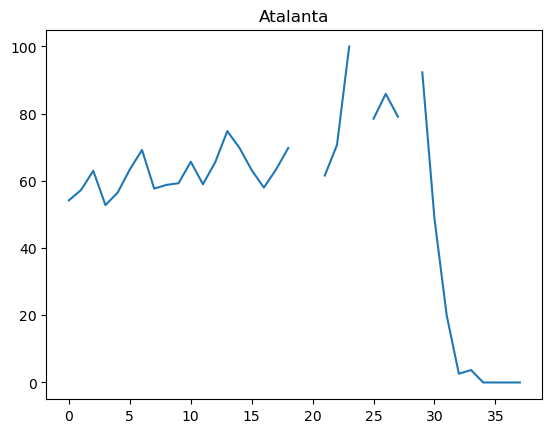

In [29]:
season = 2021
index = next(i)
plt.plot(importance(teams_na_ita_21[index], season, data=data_spi)[0])
plt.title(teams_na_ita_21[index])


In [30]:
ranking


,Rank,Team,Games Played,Points,Goals Scored,Goals Against,Goal Difference,Specific_points,Specific_GD
0,1,Lyon,1,3,4,0,4,0,0
1,2,Lille,1,3,3,0,3,0,0
2,3,Marseille,1,3,3,0,3,0,0
3,4,Paris SG,1,3,2,0,2,0,0
4,5,Guingamp,1,3,3,1,2,0,0
5,6,St Etienne,1,3,1,0,1,0,0
6,7,Montpellier,1,3,1,0,1,0,0
7,8,Monaco,1,3,3,2,1,0,0
8,9,Angers,1,1,2,2,0,1,0
9,10,Bordeaux,1,1,2,2,0,1,0


In [31]:
rankings.keys()


dict_keys(['ligue1_1718'])

In [32]:
from sklearn import linear_model
off_rating = np.array([2.7, 2.08, 1.63, 1.79, 1.51, 1.53, 1.45, 1.34, 1.54,
                       1.3, 1.9, 2.1, 2.0, 1.9, 1.7, 1.6, 1.4, 1.5, 2.0, 2.0])
def_rating_adv = np.array([0.92, 0.91, 0.68, 1.17, 1.02, 0.8, 1.2,
                          0.83, 0.7, 1.32, 1.3, 1.2, 1.1, 1.3, 1.2, 1.8, 1.1, 1.1, 1.0, 0.6])
predict_score = np.array([2.53, 1.82, 1.08, 1.86, 1.33, 1.1, 1.51, 1.13,
                         1.07, 1.38, 2.11, 2.22, 1.87, 2.05, 1.61, 1.25, 1.4, 1.44, 1.89, 1.39])
importance = np.array([65, 76.9, 2.6, 38.4, 5, 4.2, 53.7, 51.4, 46.1,
                      40.2, 72.9, 60.2, 11.1, 37.0, 22.9, 7.4, 34, 50.8, 41.1, 47.5])
importance_adv = np.array([3.4, 72.1, 45.2, 15.7, 23, 50.2, 29.9, 4.9,
                          67.7, 53.9, 39.8, 6.3, 41.9, 43.1, 52.8, 3.2, 12.9, 40.5, 48, 48])
bias = np.ones(20)
importance_diff = importance-importance_adv

regr = linear_model.LinearRegression()

df = pd.DataFrame({'offrating': off_rating, 'defrating': def_rating_adv, 'importance': importance,
                  'importance_adv': importance_adv, 'bias': bias, 'predscore': predict_score})
df = df.sample(frac=1).reset_index(drop=True)
X = df[['offrating', 'defrating', 'importance', 'importance_adv']]
y = df[['predscore']]
regr.fit(X, y)
print(regr.coef_)


[[ 9.37060922e-01  5.20498979e-01  4.70906510e-03 -7.36302290e-04]]


Text(2.1, 1.2, '0.8564')

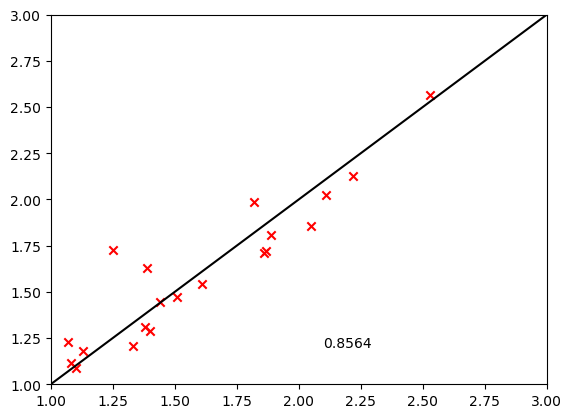

In [33]:
y_pred = regr.predict(X)
plt.scatter(y, y_pred, marker='x', color='r')
plt.plot(np.arange(0, 100, 1), np.arange(0, 100, 1), color='k')
plt.xlim(1, 3)
plt.ylim(1, 3)
plt.text(2.1, 1.2, np.round(regr.score(X, y), 4))


For now we will leave this matter unanswered. No simple model seems to link spi ratings and match importance to predicted scores, the most efficient solution to solve the missing importance data could be to drop the rows with missing information.


## Evaluation of 538's predictions


In [34]:
spi_outcomes = np.empty((len(data_spi_red), 1)).astype('str')
spi_bts = np.empty((len(data_spi_red), 1)).astype('str')
for index, row in data_spi_red.iterrows():
    if row.score1 == row.score2:
        spi_outcomes[index] = 'D'
    elif row.score1 > row.score2:
        spi_outcomes[index] = 'H'
    elif row.score1 < row.score2:
        spi_outcomes[index] = 'A'
    else:
        print(index, 'mistake')

    if (row.score1 > 0) and (row.score2 > 0):
        spi_bts = 'yes'
    elif (row.score1 == 0) or (row.score2 == 0):
        spi_bts = 'no'
    else:
        print(index, 'mistake')
data_spi_red['outcome'] = spi_outcomes
data_spi_red['bts'] = spi_bts


In [35]:
spi_rps = np.empty((len(data_spi_red), 1))
spi_bin_acc = np.empty((len(data_spi_red), 1))
spi_dbl_acc = np.empty((len(data_spi_red), 1))
spi_bts_acc = np.empty((len(data_spi_red), 1))
spi_probs = data_spi_red[['prob1', 'probtie', 'prob2']]
spi_outcomes = pd.get_dummies(data_spi_red['outcome'])[['H', 'D', 'A']]
# spi_bts = pd.get_dummies(data_spi_red['bts'])[['yes', 'no']]
for i in range(0, len(data_spi_red)):
    spi_rps[i] = rps(np.array(spi_probs.iloc[i]),
                     np.array(spi_outcomes.iloc[i]))
    spi_bin_acc[i] = binary_accuracy(
        np.array(spi_probs.iloc[i]), np.array(spi_outcomes.iloc[i]))
    spi_dbl_acc[i] = double_accuracy(
        np.array(spi_probs.iloc[i]), np.array(spi_outcomes.iloc[i]))
print('The spi predictions have a RPS value of :', spi_rps.mean())
print('The spi predictions have a binary accuracy of :',
      spi_bin_acc.mean()*100, '%')
print('The spi predictions have a double accuracy of :',
      spi_dbl_acc.mean()*100, '%')


The spi predictions have a RPS value of : 0.19705064735422181
The spi predictions have a binary accuracy of : 53.308289934261076 %
The spi predictions have a double accuracy of : 78.4000683001793 %
